# GetNumax (name work in progress)

This pipeline estimates numax and the uncertainty from a power spectra. $\nu_{\rm max}$ is measured by from the frequency of the peak amplitude from the smoothed power spectra within an envelope around a predicted numax estimate. Uncertainties are determined by peturbing the power spectrum and measuring $\nu_{\rm max}$ again, and then finding the scatter in the distributions of the measured $\nu_{\rm max}$. This code will also estimate the peak amplitude of the smoothed power spectra and the width (and uncertainties for both using the same method). Smoothing is done by colvolving the power with a Gaussian kernel (based on the nuSYD method). 

This code includes four ways to deal with the background due to granulation (white noise is always subtracted):

1. white: This will only remove the white noise from the power spectrum before estimating $\nu_{\rm max}$
2. nuSYD: divides by $(\nu/\nu_{\rm max})^{-2}$ to the power before smoothing. Removes power at lower frequencies (i.e. just removed Granulation noise). 
3. linear: estimates a linear model between the power excess envelope (same method from pySYD implement by Simon Campbell). Subtracts the linear background from power after smoothing.
4. harvey: fits a harvey-like function to the granulation noise (based on pySYD method). Subtracts the linear background from power after smoothing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft
import matplotlib as mpl
from tqdm import tqdm
from getnumax import main, main_mc
from scipy.signal import find_peaks
import os

%pylab inline --no-import-all
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=15             #10 
mpl.rcParams['savefig.dpi']= 300             #72 
mpl.rcParams['xtick.major.size']= 10           
mpl.rcParams['ytick.major.size']= 10
mpl.rcParams['xtick.minor.size']= 5           
mpl.rcParams['ytick.minor.size']= 5   
mpl.rcParams["errorbar.capsize"]= 5
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = 'M9'
star_id = 'M9RGB209'


targets = pd.read_csv(f'../{cluster}/catalogs/{cluster}_targets.csv')
target = targets.loc[targets.star_id == star_id]

numax_est = 1.229e-19*(target.Gmag.values[0])**16.89
print(f'numax estimate for {star_id}: ', numax_est)

evol_stage = target['evol_stage'].values[0]

frequency, power = np.loadtxt(f'../{cluster}/lightcurves/{star_id}/{star_id}_PS.txt').T

time, flux = np.loadtxt(f'../{cluster}/lightcurves/{star_id}/{star_id}_LC.txt').T

## Extra parameters

# Smoothing scaling parameter
sm = None

# Lower frequency to search for power excess
lowerp = None

# Upper frequency to search for power excess
upperp = None

# Background models: nuSYD, linear, harvey, white
background_model = 'nuSYD'

numax estimate for M9RGB209:  16.409434378584862


Parameters for M9RGB209:
White noise metric=  886.3810413815987  ppm^2/muHz
Right hand side of width cannot be found
Measured numax =  17.455691516383723
Measured Amplitude =  7028.10150189659
Measured width =  7.157699508192495


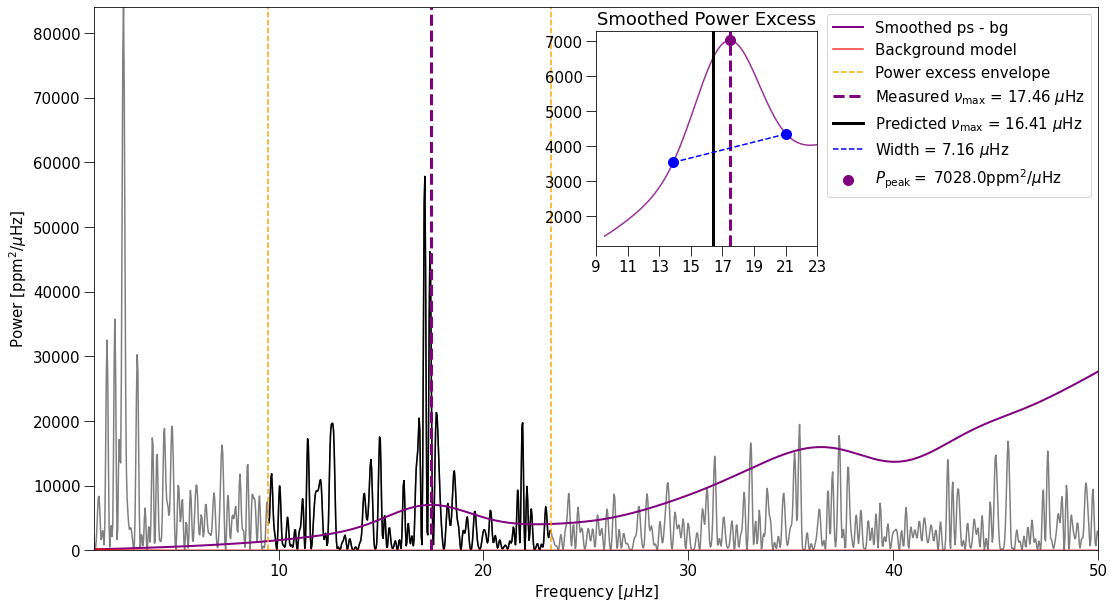

In [3]:
numax_measured, peak_measured, width_measured = main(frequency, power, time, numax_est, star_id, evol_stage, background_model = background_model,
                                                      verbose = True, plot = True, save = True, ylim_offset = 0, 
                                                      sm = sm, lowerp = lowerp, upperp = upperp)

------------------------------------------------------
Running sampling routine:


 96%|██████████████████████████████████████▏ | 478/500 [00:00<00:00, 549.51it/s]

Parameters for M9RGB209:
Measured numax =  17.455691516383723 +/- 0.20807884647534736 muHz ( 1.1920401221575598 %)
Measured Amplitude =  7028.10150189659 +/- 854.2104460201084 ppm^2/muHz
Measured width =  7.157699508192495 +/- 0.884335097520225 muHz


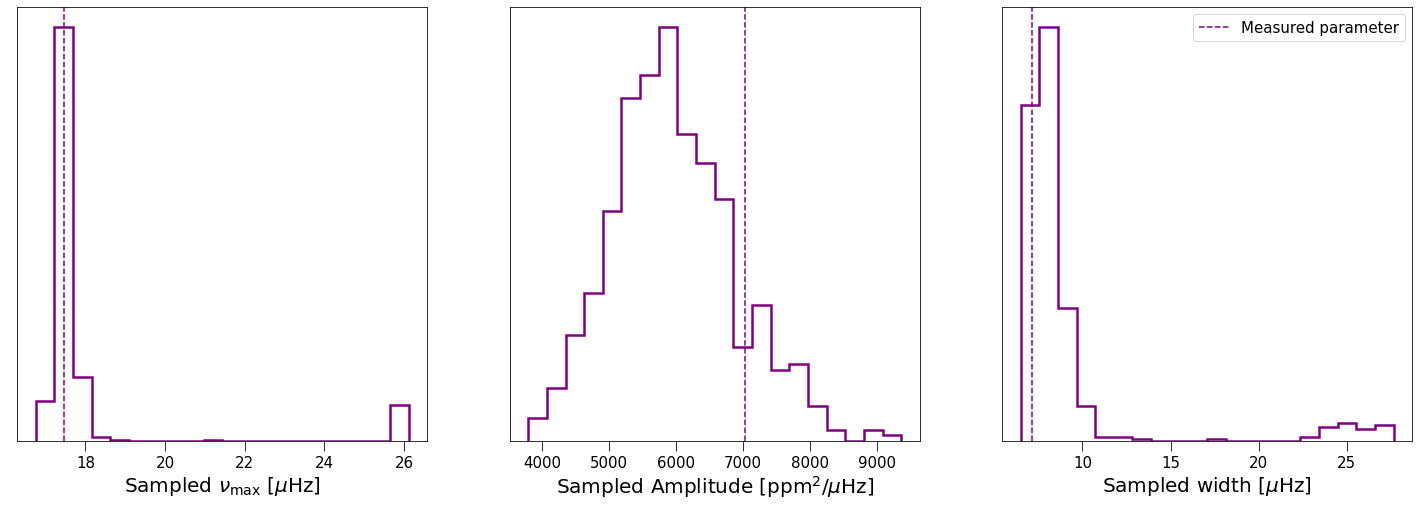

In [4]:
numax_uncertainty, peak_uncertainty, width_uncertainty = main_mc(frequency, power, time, [numax_measured, peak_measured, width_measured],
                                                         star_id, evol_stage, mc_iters = 500, verbose = True, plot = True, save = True, nyquist = 277.78, 
                                                         sm = sm, lowerp = lowerp, upperp = upperp, background_model = background_model)

In [5]:
## save file in local star directory with numax estimates

columns = ['numax', 'numax_err', 'Amplitude', 'Amplitude_err',
                                     'Width', 'Width_err', 'background_model']

values = {'numax': [numax_measured], 'numax_err': [numax_uncertainty], 
              'Amplitude': [peak_measured], 'Amplitude_err': [peak_uncertainty], 
              'Width': [width_measured], 'Width_err': [width_uncertainty], 'background_model': [background_model]}

if not os.path.isfile(f'./results/{star_id}/{star_id}_numax_results.csv'):
    df = pd.DataFrame(columns = columns)
else:
    df = pd.read_csv(f'./results/{star_id}/{star_id}_numax_results.csv')

    
if background_model in df.background_model.values:
    df.loc[df.background_model == background_model, 'numax'] = numax_measured
    df.loc[df.background_model == background_model, 'numax_err'] = numax_uncertainty
    df.loc[df.background_model == background_model, 'Amplitude'] = peak_measured
    df.loc[df.background_model == background_model, 'Amplitude_err'] = peak_uncertainty
    df.loc[df.background_model == background_model, 'Width'] = width_measured
    df.loc[df.background_model == background_model, 'Width_err'] = width_uncertainty
else:
    df_temp = pd.DataFrame(values)
    if len(df) == 0:
        df = df_temp
    else:
        df = pd.concat([df, df_temp], ignore_index = True)

    df.to_csv(f'./results/{star_id}/{star_id}_numax_results.csv', index = False)
    
    
## Save extra parameters into a file

with open(f'./results/{star_id}/{background_model}/{star_id}_extra_params_{background_model}.txt', 'w') as f:
    f.write('sm: ' + str(sm) + '\n')
    f.write('lower: ' + str(lowerp) + '\n')
    f.write('upper: ' + str(upperp) + '\n')
    
f.close()

In [6]:
## Set below to true is numax is confirmed
numax_flag = False

if numax_flag:
    ## Save seismic parameters in a csv file
    

    if not os.path.isfile(f'./results/{cluster}_nusyd_results.csv'):
        df = pd.DataFrame(columns = columns)
    else:
        df = pd.read_csv(f'./results/{cluster}_nusyd_results.csv')


    if star_id in df.star_id.values:
        df.loc[df.star_id == star_id, 'numax'] = numax_measured
        df.loc[df.star_id == star_id, 'numax_err'] = numax_uncertainty
        df.loc[df.star_id == star_id, 'Amplitude'] = peak_measured
        df.loc[df.star_id == star_id, 'Amplitude_err'] = peak_uncertainty
        df.loc[df.star_id == star_id, 'Width'] = width_measured
        df.loc[df.star_id == star_id, 'Width_err'] = width_uncertainty

    else:
        df_temp = pd.DataFrame(values)
        if len(df) == 0:
            df = df_temp
        else:
            df = pd.concat([df, df_temp], ignore_index = True)

    df.to_csv(f'./results/{cluster}_nusyd_results.csv', index = False)
else:
    print('Measured numax not saved')

Measured numax not saved
